<a href="https://colab.research.google.com/github/MattiaGatto/football-match-betting-predictions/blob/main/prediction_result_of_football_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che predice il risultato delle partite della serie A

---
# Librerie necessarie all'utilizzo

In [1]:
!pip install --upgrade pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from datetime import date
from bs4 import BeautifulSoup
# plt.style.use('fivethirtyeight')
from google.colab import drive
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load 
from pathlib import Path
from sklearn.metrics import mean_squared_error
import time
import datetime
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
drive.mount('/content/drive')

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


## Riceverò i dati attraverso il seguente url.



In [2]:
OGGI=date.today()
URL = "https://www.football-data.co.uk/italym.php"
resp = requests.get(URL)
print(resp.status_code)

200


In [3]:
import urllib
import csv

resp = requests.get(URL)
# print(resp.status_code)

# creazione di un oggetto "soup"
data = BeautifulSoup(resp.content)
# print(data)

def Dataframe_RES(path):
  try:
    res = urllib.request.urlopen('https://www.football-data.co.uk/'+path)
    df = pd.read_csv(res)
    return df
  except:
    error.append('https://www.football-data.co.uk/'+path)
    print("An exception occurred")

  
error=[]
SERIE_A=[]
SERIE_B=[]
for link in data.find_all('a'):
  l=link.get('href')
  if (str(l)[len(l)-4:]==".csv"):
    path=str(link.get('href'))
    print(path,path[len(path)-6:len(path)-4])
    if (path[len(path)-6:len(path)-4]=='I1'):
      SERIE_A.append(Dataframe_RES(path))
      print('SERIE_A')
    if (path[len(path)-6:len(path)-4]=='I2'):
      SERIE_B.append(Dataframe_RES(path))
      print('SERIE_B')

print(len(error))
for e in error:
  res = urllib.request.urlopen(e)
  df = pd.read_csv(res, encoding ='latin1', error_bad_lines=False)
  if (e[len(e)-6:len(e)-4]=='I1'):
      SERIE_A.append(df)
      print('SERIE_A')
  if (e[len(e)-6:len(e)-4]=='I2'):
    SERIE_B.append(df)
    print('SERIE_B')

mmz4281/2223/I1.csv I1
SERIE_A
mmz4281/2223/I2.csv I2
SERIE_B
mmz4281/2122/I1.csv I1
SERIE_A
mmz4281/2122/I2.csv I2
SERIE_B
mmz4281/2021/I1.csv I1
SERIE_A
mmz4281/2021/I2.csv I2
SERIE_B
mmz4281/1920/I1.csv I1
SERIE_A
mmz4281/1920/I2.csv I2
SERIE_B
mmz4281/1819/I1.csv I1
SERIE_A
mmz4281/1819/I2.csv I2
An exception occurred
SERIE_B
mmz4281/1718/I1.csv I1
SERIE_A
mmz4281/1718/I2.csv I2
SERIE_B
mmz4281/1617/I1.csv I1
SERIE_A
mmz4281/1617/I2.csv I2
SERIE_B
mmz4281/1516/I1.csv I1
SERIE_A
mmz4281/1516/I2.csv I2
SERIE_B
mmz4281/1415/I1.csv I1
SERIE_A
mmz4281/1415/I2.csv I2
SERIE_B
mmz4281/1314/I1.csv I1
SERIE_A
mmz4281/1314/I2.csv I2
SERIE_B
mmz4281/1213/I1.csv I1
SERIE_A
mmz4281/1213/I2.csv I2
SERIE_B
mmz4281/1112/I1.csv I1
SERIE_A
mmz4281/1112/I2.csv I2
SERIE_B
mmz4281/1011/I1.csv I1
SERIE_A
mmz4281/1011/I2.csv I2
SERIE_B
mmz4281/0910/I1.csv I1
SERIE_A
mmz4281/0910/I2.csv I2
SERIE_B
mmz4281/0809/I1.csv I1
SERIE_A
mmz4281/0809/I2.csv I2
SERIE_B
mmz4281/0708/I1.csv I1
SERIE_A
mmz4281/0708/I2.c

b'Skipping line 177: expected 49 fields, saw 51\nSkipping line 178: expected 49 fields, saw 51\nSkipping line 179: expected 49 fields, saw 51\nSkipping line 180: expected 49 fields, saw 51\nSkipping line 181: expected 49 fields, saw 51\nSkipping line 182: expected 49 fields, saw 51\nSkipping line 183: expected 49 fields, saw 51\nSkipping line 184: expected 49 fields, saw 51\nSkipping line 185: expected 49 fields, saw 51\nSkipping line 186: expected 49 fields, saw 51\nSkipping line 187: expected 49 fields, saw 51\nSkipping line 188: expected 49 fields, saw 51\nSkipping line 189: expected 49 fields, saw 51\nSkipping line 190: expected 49 fields, saw 51\nSkipping line 191: expected 49 fields, saw 51\nSkipping line 192: expected 49 fields, saw 51\nSkipping line 193: expected 49 fields, saw 50\nSkipping line 194: expected 49 fields, saw 50\nSkipping line 195: expected 49 fields, saw 50\nSkipping line 196: expected 49 fields, saw 50\nSkipping line 197: expected 49 fields, saw 50\nSkipping li

SERIE_A


b'Skipping line 17: expected 46 fields, saw 47\nSkipping line 18: expected 46 fields, saw 47\nSkipping line 19: expected 46 fields, saw 47\nSkipping line 20: expected 46 fields, saw 47\nSkipping line 21: expected 46 fields, saw 47\nSkipping line 22: expected 46 fields, saw 47\nSkipping line 23: expected 46 fields, saw 47\nSkipping line 24: expected 46 fields, saw 47\nSkipping line 25: expected 46 fields, saw 47\nSkipping line 26: expected 46 fields, saw 47\nSkipping line 27: expected 46 fields, saw 47\nSkipping line 28: expected 46 fields, saw 47\nSkipping line 29: expected 46 fields, saw 47\nSkipping line 30: expected 46 fields, saw 47\nSkipping line 31: expected 46 fields, saw 47\nSkipping line 32: expected 46 fields, saw 47\nSkipping line 33: expected 46 fields, saw 47\nSkipping line 34: expected 46 fields, saw 47\nSkipping line 35: expected 46 fields, saw 47\nSkipping line 36: expected 46 fields, saw 47\nSkipping line 37: expected 46 fields, saw 47\nSkipping line 38: expected 46 fi

SERIE_B


b'Skipping line 49: expected 45 fields, saw 46\nSkipping line 50: expected 45 fields, saw 46\nSkipping line 51: expected 45 fields, saw 46\nSkipping line 52: expected 45 fields, saw 46\nSkipping line 53: expected 45 fields, saw 46\nSkipping line 54: expected 45 fields, saw 46\nSkipping line 55: expected 45 fields, saw 46\nSkipping line 56: expected 45 fields, saw 46\nSkipping line 57: expected 45 fields, saw 46\nSkipping line 58: expected 45 fields, saw 46\nSkipping line 59: expected 45 fields, saw 46\nSkipping line 60: expected 45 fields, saw 46\nSkipping line 61: expected 45 fields, saw 46\nSkipping line 62: expected 45 fields, saw 46\nSkipping line 63: expected 45 fields, saw 46\nSkipping line 64: expected 45 fields, saw 46\nSkipping line 81: expected 45 fields, saw 49\nSkipping line 82: expected 45 fields, saw 49\nSkipping line 83: expected 45 fields, saw 49\nSkipping line 84: expected 45 fields, saw 49\nSkipping line 85: expected 45 fields, saw 49\nSkipping line 86: expected 45 fi

SERIE_A


b'Skipping line 81: expected 42 fields, saw 49\nSkipping line 82: expected 42 fields, saw 49\nSkipping line 83: expected 42 fields, saw 49\nSkipping line 84: expected 42 fields, saw 49\nSkipping line 85: expected 42 fields, saw 49\nSkipping line 86: expected 42 fields, saw 49\nSkipping line 87: expected 42 fields, saw 49\nSkipping line 88: expected 42 fields, saw 49\nSkipping line 89: expected 42 fields, saw 49\nSkipping line 90: expected 42 fields, saw 49\nSkipping line 91: expected 42 fields, saw 49\nSkipping line 92: expected 42 fields, saw 49\nSkipping line 93: expected 42 fields, saw 49\nSkipping line 94: expected 42 fields, saw 49\nSkipping line 95: expected 42 fields, saw 49\nSkipping line 96: expected 42 fields, saw 49\nSkipping line 97: expected 42 fields, saw 53\nSkipping line 98: expected 42 fields, saw 53\nSkipping line 99: expected 42 fields, saw 53\nSkipping line 100: expected 42 fields, saw 53\nSkipping line 101: expected 42 fields, saw 53\nSkipping line 102: expected 42

SERIE_B


b'Skipping line 97: expected 30 fields, saw 32\nSkipping line 98: expected 30 fields, saw 32\nSkipping line 99: expected 30 fields, saw 32\nSkipping line 100: expected 30 fields, saw 32\nSkipping line 101: expected 30 fields, saw 32\nSkipping line 102: expected 30 fields, saw 32\nSkipping line 103: expected 30 fields, saw 32\nSkipping line 104: expected 30 fields, saw 32\nSkipping line 105: expected 30 fields, saw 32\nSkipping line 106: expected 30 fields, saw 32\nSkipping line 107: expected 30 fields, saw 32\nSkipping line 108: expected 30 fields, saw 32\nSkipping line 109: expected 30 fields, saw 32\nSkipping line 110: expected 30 fields, saw 32\nSkipping line 111: expected 30 fields, saw 32\nSkipping line 112: expected 30 fields, saw 32\nSkipping line 129: expected 30 fields, saw 32\nSkipping line 130: expected 30 fields, saw 32\nSkipping line 131: expected 30 fields, saw 32\nSkipping line 132: expected 30 fields, saw 32\nSkipping line 133: expected 30 fields, saw 32\nSkipping line 

SERIE_B
SERIE_B


b'Skipping line 305: expected 22 fields, saw 25\nSkipping line 306: expected 22 fields, saw 25\nSkipping line 307: expected 22 fields, saw 25\nSkipping line 308: expected 22 fields, saw 25\nSkipping line 309: expected 22 fields, saw 25\nSkipping line 310: expected 22 fields, saw 25\nSkipping line 311: expected 22 fields, saw 25\nSkipping line 312: expected 22 fields, saw 25\nSkipping line 313: expected 22 fields, saw 25\nSkipping line 314: expected 22 fields, saw 25\nSkipping line 315: expected 22 fields, saw 25\nSkipping line 316: expected 22 fields, saw 25\nSkipping line 317: expected 22 fields, saw 25\nSkipping line 318: expected 22 fields, saw 25\nSkipping line 319: expected 22 fields, saw 25\nSkipping line 320: expected 22 fields, saw 25\nSkipping line 321: expected 22 fields, saw 28\nSkipping line 322: expected 22 fields, saw 28\nSkipping line 323: expected 22 fields, saw 28\nSkipping line 324: expected 22 fields, saw 28\nSkipping line 325: expected 22 fields, saw 28\nSkipping li

Note per i dati di calcio

Tutti i dati sono in formato csv, pronti per l'uso all'interno di applicazioni di fogli di calcolo standard. Si prega di notare che alcune abbreviazioni non sono più in uso (in particolare le quote di specifici bookmaker non più utilizzate) e si riferiscono ai dati raccolti nelle stagioni precedenti. Per un elenco aggiornato di quali bookmaker sono inclusi nel set di dati, visitare http://www.football-data.co.uk/matches.php

Chiave per i dati dei risultati:

Div = Divisione League

Date = Data della partita (gg/mm/aa)

Time = Momento del calcio d'inizio della partita

HomeTeam = Squadra di casa

AwayTeam = Squadra ospite

FTHG and HG = Obiettivi della squadra di casa a tempo pieno

FTAG and AG = Obiettivi di squadra in trasferta a tempo pieno

FTR and Res = Risultato a tempo pieno (h=vittoria in casa, D=pareggio, a=vittoria in trasferta)

HTHG = Gol della squadra di casa a metà tempo

HTAG = Gol di squadra in trasferta a metà tempo

HTR = Risultato del primo tempo (h=vittoria in casa, D=pareggio, a=vittoria in trasferta)

Statistiche delle partite (ove disponibili)

Attendance = Affluenza alla folla

Referee = Arbitro della partita

HS = Colpi della squadra di casa

AS = Tiri in trasferta

HST = Colpi della squadra di casa sul bersaglio

AST = Tiri in trasferta sul bersaglio

HHW = Home Team Hit Woodwork

AHW = Squadra in trasferta Hit Woodwork

HC = Corner della squadra di casa

AC = Angoli della squadra in trasferta

HF = Fallo commesso dalla squadra di casa

AF = Falli commessi in trasferta

HFKC = Calci di punizione concessi dalla squadra di casa

AFKC = Calci di punizione concessi dalla squadra ospite

HO = Fuorigioco della squadra di casa

AO = Fuorigioco della squadra in trasferta

HY = Cartellini gialli della squadra di casa

AY = Cartellini gialli della squadra ospite

HR = Cartellini rossi della squadra di casa

AR = Cartellini rossi della squadra in trasferta

HBP = Home Team Bookings Points (10 = giallo, 25 = rosso)

ABP = Punti Prenotazioni Squadre Away (10 = giallo, 25 = rosso)

Si noti che i calci di punizione conceeded includono falli, fuorigioco e qualsiasi altra offesa commessa e saranno sempre uguali o superiori al numero di falli. I falli costituiscono la stragrande maggioranza dei calci di punizione concessi. I calci di punizione concessi vengono mostrati quando non sono disponibili dati specifici sui falli (Francia 2a, Belgio 1a e Grecia 1a divisione).

Si noti inoltre che i cartellini gialli inglesi e scozzesi non includono il cartellino giallo iniziale quando un secondo viene mostrato a un giocatore che lo converte in rosso, ma questo è incluso come giallo (più rosso) per le partite europee.


Chiave per i dati sulle quote di scommessa 1X2 (partita):

B365H = Bet365 quote vittoria in casa

B365D = Quote di estrazione Bet365

B365A = Bet365 quote vittoria in trasferta

BSH = Blue Square quote di vittoria in casa

BSD = Quote di estrazione Blue Square

BSA = Blue Square quote di vittoria in trasferta

BWH = Quote di vincita in casa Bet&Win

BWD = Quote di estrazione Bet&Win

BWA = Quote di vincita in trasferta Bet&Win

GBH = Quote di vincita in casa di Gamebookers

GBD = Quote di sorteggio Gamebookers

GBA = Quote di vincita in trasferta dei Gamebookers

IWH = Quote di vittoria in casa Interwetten

IWD = Quote di pareggio Interwetten

IWA = Quote di vittoria in trasferta interwetten

LBH = Ladbrokes quote di vittoria in casa

LBD = Quote di estrazione di Ladbrokes

LBA = Ladbrokes in trasferta quote di vittoria

PSH e PH = Pinnacle quote di vittoria in casa

PSD e PD = Quote di pareggio Pinnacle

PSA e PA = Pinnacle quote di vittoria in trasferta

SOH = Sporting Odds quote vittoria in casa

SOD = Quote sportive quote di estrazione

SOA = Quote Sportive quote vittoria in trasferta

SBH = Sportingbet quote di vittoria in casa

SBD = Quote di pareggio Sportingbet

SBA = Sportingbet quote vittoria in trasferta

SJH = Stan James quote di vittoria in casa

SJD = Stan James pareggio quote

SJA = Stan James in trasferta quote vittoria

SYH = Stanleybet quote di vittoria in casa

SYD = Stanleybet quote di pareggio

SYA = Stanleybet in trasferta quote di vittoria

VCH = VC Bet quote di vincita in casa

VCD = Vc Bet quote di estrazione

VCA = VC Bet quote di vincita in trasferta

WHH = William Hill quote vittoria in casa

WHD = William Hill quote di pareggio

WHA = William Hill in trasferta quote vittoria

Bb1X2 = Numero di bookmaker BetBrain utilizzati per calcolare le medie e i massimi delle quote delle partite

BbMxH = Betbrain massimo di vincita in casa

BbAvH = Betbrain probabilità medie di vittoria in casa

BbMxD = Betbrain quote di pareggio massimo

BbAvD = Betbrain media delle quote di vincita

BbMxA = Betbrain massimo di vittorie in trasferta

BbAvA = Betbrain media di vittorie in trasferta

MaxH = Quote di vincita in casa massime del mercato

MaxD = Quote di vincita massima del pareggio di mercato

MaxA = Quote di vincita in trasferta massime del mercato

AvgH = Probabilità di vincita in casa medie di mercato

AvgD = Quote di vincita medie del mercato

AvgA = Quote di vincita in trasferta medie di mercato



Chiave per le quote totali di scommessa sugli obiettivi:


BbOU = Numero di bookmaker BetBrain utilizzati per calcolare medie e massimi di over/under 2,5 goal (goal totali)

BbMx>2.5 = Betbrain massimo oltre 2.5 goal

BbAv>2.5 = Betbrain media oltre 2.5 gol

BbMx<2.5 = Betbrain massimo sotto i 2.5 gol

BbAv<2.5 = Betbrain media sotto i 2.5 gol



GB>2.5 = Gamebookers oltre 2.5 gol

GB<2.5 = Gamebookers sotto i 2,5 gol

B365>2.5 = Bet365 oltre 2.5 gol

B365<2.5 = Bet365 sotto i 2,5 gol

P>2.5 = Pinnacle oltre 2.5 gol

P<2.5 = Pinnacle sotto i 2,5 gol

Max>2.5 = Massimo di mercato oltre 2,5 obiettivi

Max<2.5 = Massimo di mercato sotto i 2,5 obiettivi

Avg>2.5 = Media di mercato superiore a 2,5 gol

Avg <2,5 = Media di mercato inferiore a 2,5 gol




Chiave per le quote di scommesse con handicap asiatico:

BbAH = Numero di bookmaker BetBrain utilizzati per medie e massimi di handicap asiatici

BbAHh = Betbrain dimensione dell'handicap (squadra di casa)

AHh = Dimensione del mercato dell'handicap (squadra di casa) (dal 2019/2020)

BbMxAHH = Betbrain massimo asiatico handicap squadra di casa quote

BbAvAHH = Betbrain media asiatica handicap squadra di casa quote

BbMxAHA = Betbrain massimo handicap asiatico in trasferta quote squadra

BbAvAHA = Betbrain media asiatica handicap in trasferta quote squadra



GBAHH = Quote della squadra di casa con handicap asiatico gamebookers

GBAHA = Quote squadra in trasferta handicap asiatico Gamebookers

GBAH = Gamebookers dimensione dell'handicap (squadra di casa)

LBAHH = Ladbrokes Asian handicap squadra di casa quote

LBAHA = Ladbrokes Asian handicap away team odds

LBAH = Ladbrokes dimensione dell'handicap (squadra di casa)

B365AHH = Bet365 Asian handicap home team quote

B365AHA = Bet365 Asian handicap quote squadra in trasferta

B365AH = Bet365 dimensione dell'handicap (squadra di casa)

PAHH = Pinnacle Asian handicap squadra di casa quote

PAHA = Pinnacle Asian handicap quote squadra in trasferta

MaxAHH = Quote di squadra di casa con handicap asiatico massimo di mercato

MaxAHA = Quote di squadra in trasferta con handicap asiatico massimo di mercato	

AvgAHH = Quote medie di mercato della squadra di casa asiatica

AvgAHA = Quote medie di mercato della squadra asiatica handicap in trasferta



Quote di chiusura (ultime quote prima dell'inizio della partita)

Come sopra ma con un carattere "C" aggiuntivo che segue l'abbreviazione del bookmaker / Max / Avg

Football-Data desidera riconoscere le seguenti fonti che sono state utilizzate nella compilazione dei risultati e dei file delle quote di Football-Data.


Risultati attuali (tempo pieno, metà tempo)
XScores - http://www.xscores .com

Statistiche delle partite
BBC, ESPN Soccer, Bundesliga.de, Gazzetta.it e Football.fr

Quote scommesse bookmakers
Bookmaker individuali

Le quote di scommessa per le partite del fine settimana vengono raccolte il venerdì pomeriggio e il martedì pomeriggio per le partite infrasettimanali.

Ulteriori statistiche delle partite (corner, tiri, prenotazioni, arbitro, ecc.) per le stagioni 2000/01 e 2001/02 per i campionati inglese, scozzese e tedesco sono state fornite da Sports.com (ora sotto nuova proprietà e non più disponibile).



In [4]:
ds_serieA=SERIE_A[0]
for da in SERIE_A[1:]:
  ds_serieA=ds_serieA.append(da, ignore_index=True).reset_index(drop=True)
ds_serieB=SERIE_B[0]
for db in SERIE_B[1:]:
  ds_serieB=ds_serieB.append(db, ignore_index=True).reset_index(drop=True)
ds_serieB

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 33,Unnamed: 34,Unnamed: 35,SYH,SYD,SYA
0,I2,12/08/2022,19:45,Parma,Bari,2.0,2.0,D,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I2,13/08/2022,19:45,Cittadella,Pisa,4.0,3.0,H,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I2,13/08/2022,19:45,Como,Cagliari,1.0,1.0,D,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I2,13/08/2022,19:45,Palermo,Perugia,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I2,14/08/2022,19:45,Ascoli,Ternana,2.0,1.0,H,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10166,I2,02/06/02,NaN,Modena,Salernitana,5.0,2.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10167,I2,02/06/02,NaN,Napoli,Como,1.0,2.0,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10168,I2,02/06/02,NaN,Palermo,Ancona,2.0,3.0,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10169,I2,02/06/02,NaN,Reggina,Genoa,2.0,2.0,D,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
matches=ds_serieA.append(ds_serieB, ignore_index=True).reset_index(drop=True)
# matches.info

In [6]:
x=matches.isnull().sum()
eliminate=[]

In [7]:
count=0
for col in range (len(x)):
  if(x[col]>=len(matches)-1000):
    count+=1
    matches=matches.drop([x.keys()[col]],axis=1)
    eliminate.append(x.keys()[col])
print('count=',count)

count= 57


In [8]:
matches['FTR']

0        H
1        A
2        A
3        A
4        H
        ..
21504    H
21505    A
21506    A
21507    D
21508    A
Name: FTR, Length: 21509, dtype: object

In [9]:
matches['risultato']=matches['FTR']
matches['risultato'][matches['risultato']=="A"]="2"
matches['risultato'][matches['risultato']=="D"]="X"
matches['risultato'][matches['risultato']=="H"]="1"
# matches

In [10]:
dataset=matches[["Date","HomeTeam","AwayTeam","B365H","B365D","B365A","BWH","BWD","BWA","IWH","IWD","IWA","PSH","PSD","PSA","WHH","WHD","WHA","VCH","VCD","VCA","risultato"]]
dataset=dataset.dropna()
dataset

,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,risultato
0,13/08/2022,Milan,Udinese,1.44,4.75,7.00,1.41,4.75,7.50,1.40,...,1.43,4.66,8.84,1.38,4.60,8.50,1.36,4.6,9.00,1
1,13/08/2022,Sampdoria,Atalanta,4.33,3.90,1.75,4.33,3.80,1.77,4.30,...,4.72,3.98,1.78,4.50,3.80,1.73,4.75,3.7,1.73,2
2,13/08/2022,Lecce,Inter,10.00,5.75,1.28,9.75,5.50,1.30,9.50,...,10.75,5.92,1.31,11.00,5.50,1.27,12.00,5.5,1.25,2
3,13/08/2022,Monza,Torino,2.60,3.30,2.75,2.55,3.25,2.80,2.60,...,2.64,3.36,2.90,2.50,3.25,2.80,2.55,3.1,2.88,2
4,14/08/2022,Fiorentina,Cremonese,1.36,5.00,8.50,1.39,4.80,7.75,1.40,...,1.39,5.33,8.49,1.36,4.60,9.00,1.33,4.8,9.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20591,11/05/2019,Padova,Livorno,6.50,3.80,1.55,5.75,3.60,1.60,5.60,...,5.90,3.87,1.62,6.00,3.80,1.55,6.50,3.8,1.60,X
20592,11/05/2019,Palermo,Cittadella,1.66,3.50,5.50,1.67,3.60,5.00,1.70,...,1.77,3.47,5.28,1.70,3.60,5.00,1.73,3.6,5.20,X
20593,11/05/2019,Perugia,Cremonese,2.25,3.10,3.40,2.20,3.10,3.25,2.15,...,2.31,3.28,3.34,2.20,3.20,3.25,2.25,3.2,3.40,1
20594,11/05/2019,Pescara,Salernitana,2.15,3.20,3.50,2.30,3.10,3.10,2.15,...,2.27,3.16,3.57,2.15,3.25,3.40,2.20,3.3,3.40,1


In [11]:
new_date=[]
for date in dataset['Date']:
  date_string = str(date)
  timestamp=0.0
  try:
    timestamp = time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple())
  except:
    date_string=date_string[:len(date_string)-2]+'20'+date_string[len(date_string)-2:]
    timestamp = time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple())
  new_date.append(timestamp)
dataset['Date']=new_date

In [12]:
list_home_team=dataset['HomeTeam'].unique()
list_home_team.sort()
list_away_team=dataset['AwayTeam'].unique()
list_away_team.sort()
print(list_away_team==list_home_team)
team_dict=dict(zip(list_home_team,np.arange(len(list_home_team))))
for k in team_dict:
  dataset['HomeTeam'][matches['HomeTeam']==k]=team_dict[k]
  dataset['AwayTeam'][matches['AwayTeam']==k]=team_dict[k]

dataset

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,risultato
0,1.660349e+09,31,57,1.44,4.75,7.00,1.41,4.75,7.50,1.40,...,1.43,4.66,8.84,1.38,4.60,8.50,1.36,4.6,9.00,1
1,1.660349e+09,48,2,4.33,3.90,1.75,4.33,3.80,1.77,4.30,...,4.72,3.98,1.78,4.50,3.80,1.73,4.75,3.7,1.73,2
2,1.660349e+09,29,24,10.00,5.75,1.28,9.75,5.50,1.30,9.50,...,10.75,5.92,1.31,11.00,5.50,1.27,12.00,5.5,1.25,2
3,1.660349e+09,33,55,2.60,3.30,2.75,2.55,3.25,2.80,2.60,...,2.64,3.36,2.90,2.50,3.25,2.80,2.55,3.1,2.88,2
4,1.660435e+09,19,16,1.36,5.00,8.50,1.39,4.80,7.75,1.40,...,1.39,5.33,8.49,1.36,4.60,9.00,1.33,4.8,9.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20591,1.557533e+09,36,30,6.50,3.80,1.55,5.75,3.60,1.60,5.60,...,5.90,3.87,1.62,6.00,3.80,1.55,6.50,3.8,1.60,X
20592,1.557533e+09,37,13,1.66,3.50,5.50,1.67,3.60,5.00,1.70,...,1.77,3.47,5.28,1.70,3.60,5.00,1.73,3.6,5.20,X
20593,1.557533e+09,39,16,2.25,3.10,3.40,2.20,3.10,3.25,2.15,...,2.31,3.28,3.34,2.20,3.20,3.25,2.25,3.2,3.40,1
20594,1.557533e+09,40,47,2.15,3.20,3.50,2.30,3.10,3.10,2.15,...,2.27,3.16,3.57,2.15,3.25,3.40,2.20,3.3,3.40,1


In [13]:
labels=['1','2','X']
print(dataset['risultato'].value_counts())
# dataset['risultato'][dataset['risultato']=="1"]=0
# dataset['risultato'][dataset['risultato']=="2"]=1
# dataset['risultato'][dataset['risultato']=="X"]=2

1    3414
X    2259
2    2215
Name: risultato, dtype: int64


In [14]:
X=dataset.drop('risultato',axis=1)
Y=dataset['risultato']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30,stratify=Y, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.33,stratify=y_test, random_state=42)

y_train=y_train.astype('str')
y_validation=y_validation.astype('str')
y_test=y_test.astype('str')

In [15]:
print(y_train.value_counts())

1    2390
X    1581
2    1550
Name: risultato, dtype: int64


In [16]:
scaler=StandardScaler()
x_train=pd.DataFrame(scaler.fit_transform(x_train))
x_validation=pd.DataFrame(scaler.transform(x_validation))
x_test=pd.DataFrame(scaler.transform(x_test))

---
# MODEL TRAINING

In [17]:
#caricamento 
def load_model(model_path, model):
    model=load(model_path)
    return model

#salvataggio
def save_model(model,model_path):
    dump(model,model_path)
    return model
    
def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
          esiste=True
    except IOError:
        print("File not accessible")
    print("Il modello addestrato esiste?",esiste)
    return esiste

---
#SVM

In [18]:
from sklearn.svm import SVC

In [19]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_SVM_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_SVM_Scaler_ep.model
Il modello addestrato esiste? True


In [20]:
# SVC
if exist_model==False:
  model_SVC=SVC()
  # define the ovr strategy
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC.fit(x_train, y_train)
  ovr_SVC=save_model(ovr_SVC,path_name)
else:
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC=load_model(path_name, ovr_SVC)

In [21]:
y_pred_SVC=ovr_SVC.predict(x_validation)
print(accuracy_score(y_validation,y_pred_SVC))
print(classification_report(y_validation,y_pred_SVC))

0.5072555205047319
              precision    recall  f1-score   support

           1       0.52      0.81      0.63       686
           2       0.52      0.45      0.48       445
           X       0.39      0.11      0.17       454

    accuracy                           0.51      1585
   macro avg       0.47      0.46      0.43      1585
weighted avg       0.48      0.51      0.46      1585



---
#RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_RandomForestClassifier_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_RandomForestClassifier_Scaler_ep.model
Il modello addestrato esiste? True


In [24]:
# RandomForest
if exist_model==False:
  model_RandomForest=RandomForestClassifier()
  # define the ovr strategy
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest.fit(x_train, y_train)
  ovr_RandomForest=save_model(ovr_RandomForest,path_name)
else:
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=load_model(path_name, ovr_RandomForest)

In [25]:
y_pred_RandomForest=ovr_RandomForest.predict(x_validation)
print(accuracy_score(y_validation,y_pred_RandomForest))
print(classification_report(y_validation,y_pred_RandomForest))

0.49842271293375395
              precision    recall  f1-score   support

           1       0.53      0.76      0.62       686
           2       0.51      0.42      0.46       445
           X       0.36      0.19      0.24       454

    accuracy                           0.50      1585
   macro avg       0.46      0.45      0.44      1585
weighted avg       0.47      0.50      0.47      1585



---
#DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_DecisionTree_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_DecisionTree_Scaler_ep.model
Il modello addestrato esiste? True


In [28]:
# DecisionTree
if exist_model==False:
  model_DecisionTree=DecisionTreeClassifier()
  # define the ovr strategy
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree.fit(x_train, y_train)
  ovr_DecisionTree=save_model(ovr_DecisionTree,path_name)
else:
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree=load_model(path_name, ovr_DecisionTree)

In [29]:
y_pred_DecisionTree=ovr_DecisionTree.predict(x_validation)
print(accuracy_score(y_validation,y_pred_DecisionTree))
print(classification_report(y_validation,y_pred_DecisionTree))

0.38422712933753944
              precision    recall  f1-score   support

           1       0.55      0.33      0.42       686
           2       0.37      0.27      0.31       445
           X       0.31      0.57      0.40       454

    accuracy                           0.38      1585
   macro avg       0.41      0.39      0.38      1585
weighted avg       0.43      0.38      0.38      1585



---
#kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_KNearestNeighbors_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_KNearestNeighbors_Scaler_ep.model
Il modello addestrato esiste? True


In [32]:
# kNN
if exist_model==False:
  model_kNN=KNeighborsClassifier()
  # define the ovr strategy
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN.fit(x_train, y_train)
  ovr_kNN=save_model(ovr_kNN,path_name)
else:
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN=load_model(path_name, ovr_kNN)

In [33]:
y_pred_kNN=ovr_kNN.predict(x_validation)
print(accuracy_score(y_validation,y_pred_kNN))
print(classification_report(y_validation,y_pred_kNN))

0.4302839116719243
              precision    recall  f1-score   support

           1       0.55      0.53      0.54       686
           2       0.40      0.38      0.39       445
           X       0.29      0.33      0.31       454

    accuracy                           0.43      1585
   macro avg       0.42      0.41      0.41      1585
weighted avg       0.44      0.43      0.43      1585



---
#AdaBoost Classifier



In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_AdaBoostClassifier_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_AdaBoostClassifier_Scaler_ep.model
Il modello addestrato esiste? True


In [36]:
# AdaBoostClassifier
if exist_model==False:
  model_AdaBoost=AdaBoostClassifier()
  # define the ovr strategy
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost.fit(x_train, y_train)
  ovr_AdaBoost=save_model(ovr_AdaBoost,path_name)
else:
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost=load_model(path_name, ovr_AdaBoost)

In [37]:
y_pred_AdaBoost=ovr_AdaBoost.predict(x_validation)
print(accuracy_score(y_validation,y_pred_AdaBoost))
print(classification_report(y_validation,y_pred_AdaBoost))

0.5041009463722398
              precision    recall  f1-score   support

           1       0.53      0.80      0.63       686
           2       0.47      0.51      0.49       445
           X       0.37      0.05      0.09       454

    accuracy                           0.50      1585
   macro avg       0.46      0.45      0.41      1585
weighted avg       0.47      0.50      0.44      1585



---
#Neural Networks



In [38]:
from tensorflow import keras

In [39]:
#Costruiamo il network model
def Neural_network_model():
  model = keras.Sequential([
    keras.layers.Dense(32,input_dim=21,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(3,activation='softmax')
  ])
  return model

model=Neural_network_model()

#Compila il modello model.compile
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
y_train_enc=pd.get_dummies(y_train)
y_validation_enc=pd.get_dummies(y_validation)
y_test_enc=pd.get_dummies(y_test)

In [41]:
epochs=500
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_NNClassifier_Scaler_"+str(epochs)+"_ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_NNClassifier_Scaler_500_ep.model
Il modello addestrato esiste? True


In [42]:
# NeuralNet
if exist_model==False:
  history=model.fit(x_train,y_train_enc, epochs=epochs,validation_split=0.2)
  history=save_model(history,path_name)
else:
  history=load_model(path_name, model)

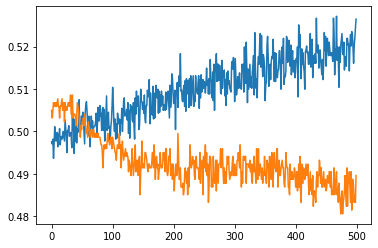

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

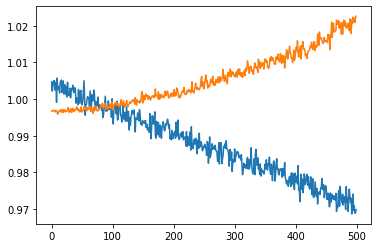

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [45]:
y_pred_NN=model.predict(x_validation)
y_pred_NN=np.argmax(y_pred_NN,axis=1)
y_pred_NN_enc=pd.get_dummies(y_pred_NN)
print(accuracy_score(y_validation_enc,y_pred_NN_enc))
print(classification_report(y_validation_enc,y_pred_NN_enc))

0.3665615141955836
              precision    recall  f1-score   support

           0       0.42      0.54      0.48       686
           1       0.25      0.08      0.12       445
           2       0.31      0.38      0.34       454

   micro avg       0.37      0.37      0.37      1585
   macro avg       0.33      0.34      0.31      1585
weighted avg       0.34      0.37      0.34      1585
 samples avg       0.37      0.37      0.37      1585



---
Confronto su un nuovo dataset per determinare il classificatore migliore

In [46]:
ris_model=dict()

y_pred_SVC_test=ovr_SVC.predict(x_test)
acc_prediction_SVC=accuracy_score(y_test,y_pred_SVC_test)
classification_report_prediction_SVC=classification_report(y_test,y_pred_SVC_test)
weighted_avg_SVC=float(classification_report_prediction_SVC.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nSVC\naccuracy:",acc_prediction_SVC,"\nweighted avg:",weighted_avg_SVC)
print(classification_report_prediction_SVC)
ris_model['SVC']=weighted_avg_SVC

y_pred_RandomForest_test=ovr_RandomForest.predict(x_test)
acc_prediction_RandomForest=accuracy_score(y_test,y_pred_RandomForest_test)
classification_report_prediction_RandomForest=classification_report(y_test,y_pred_RandomForest_test)
weighted_avg_RandomForest=float(classification_report_prediction_RandomForest.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nRandomForest\naccuracy:",acc_prediction_RandomForest,"\nweighted avg:",weighted_avg_RandomForest)
print(classification_report_prediction_RandomForest)
ris_model['RandomForest']=weighted_avg_RandomForest

y_pred_DecisionTree_test=ovr_DecisionTree.predict(x_test)
acc_prediction_DecisionTree=accuracy_score(y_test,y_pred_DecisionTree_test)
classification_report_prediction_DecisionTree=classification_report(y_test,y_pred_DecisionTree_test)
weighted_avg_DecisionTree=float(classification_report_prediction_DecisionTree.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nDecisionTree\naccuracy:",acc_prediction_DecisionTree,"\nweighted avg:",weighted_avg_DecisionTree)
print(classification_report_prediction_DecisionTree)
ris_model['DecisionTree']=weighted_avg_DecisionTree

y_pred_kNN_test=ovr_kNN.predict(x_test)
acc_prediction_kNN=accuracy_score(y_test,y_pred_kNN_test)
classification_report_prediction_kNN=classification_report(y_test,y_pred_kNN_test)
weighted_avg_kNN=float(classification_report_prediction_kNN.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nkNN\naccuracy:",acc_prediction_kNN,"\nweighted avg:",weighted_avg_kNN)
print(classification_report_prediction_kNN)
ris_model['kNN']=weighted_avg_kNN

y_pred_AdaBoost_test=ovr_AdaBoost.predict(x_test)
acc_prediction_AdaBoost=accuracy_score(y_test,y_pred_AdaBoost_test)
classification_report_prediction_AdaBoost=classification_report(y_test,y_pred_AdaBoost_test)
weighted_avg_AdaBoost=float(classification_report_prediction_AdaBoost.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nAdaBoost\naccuracy:",acc_prediction_AdaBoost,"\nweighted avg:",weighted_avg_AdaBoost)
print(classification_report_prediction_AdaBoost)
ris_model['AdaBoost']=weighted_avg_AdaBoost

y_pred_NN_test=model.predict(x_test)
y_pred_NN_test=np.argmax(y_pred_NN_test,axis=1)
y_pred_NN_test_enc=pd.get_dummies(y_pred_NN_test)
acc_prediction_NN=accuracy_score(y_test_enc,y_pred_NN_test_enc)
classification_report_prediction_NN=classification_report(y_test_enc,y_pred_NN_test_enc)
weighted_avg_NN=float(classification_report_prediction_NN.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nNeuralNetwork\naccuracy:",acc_prediction_NN,"\nweighted avg:",weighted_avg_NN)
print(classification_report_prediction_NN)
ris_model['NeuralNetwork']=weighted_avg_NN

max_acc_model=max(ris_model.values())
print("Il miglior modello è :",list(ris_model.keys())[list(ris_model.values()).index(max_acc_model)])

_______________________________________________________
SVC
accuracy: 0.4948849104859335 
weighted avg: 0.44
              precision    recall  f1-score   support

           1       0.52      0.78      0.62       338
           2       0.50      0.51      0.51       220
           X       0.22      0.05      0.09       224

    accuracy                           0.49       782
   macro avg       0.41      0.45      0.41       782
weighted avg       0.43      0.49      0.44       782

_______________________________________________________
RandomForest
accuracy: 0.4744245524296675 
weighted avg: 0.45
              precision    recall  f1-score   support

           1       0.52      0.69      0.59       338
           2       0.49      0.46      0.48       220
           X       0.30      0.17      0.21       224

    accuracy                           0.47       782
   macro avg       0.43      0.44      0.43       782
weighted avg       0.45      0.47      0.45       782

___________

Se confrontiamo i rapporti di classificazione di tutti i classificatori che abbiamo provato, possiamo vedere che il classificatore RandomForest ha ottenuto i risultati migliori. Possiamo eseguire l'ottimizzazione degli iperparametri per AdaBoost per migliorare le prestazioni e trovare il miglior set di valori di iperparametri. Userò GridSearchCV per ottimizzare i parametri learning_rate e n_estimators. Come metrica di punteggio, abbiamo scelto "f1_weighted" che assegna un peso di classe in base alla distribuzione delle classi. 

## RandomForest OPT

In [86]:
from sklearn.model_selection import GridSearchCV
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_RandomForestClassifier_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)


# RandomForest
if exist_model==False:
  params={
    'estimator__bootstrap': [True, False],
    'estimator__max_depth': [10, 20, None],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__min_samples_split': [2, 4],
    'estimator__n_estimators': [10, 20]
  }
  classes=y_train.unique()
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  grid_clf=GridSearchCV(estimator=ovr_RandomForest, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  # model_RandomForest=grid_clf.best_estimator_

  # # define the ovr strategy
  # ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=grid_clf.best_estimator_
  ovr_RandomForest.fit(x_train, y_train)
  ovr_RandomForest=save_model(ovr_RandomForest,path_name)
else:
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=load_model(path_name, ovr_RandomForest)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_RandomForestClassifier_Scaler_OPT_ep.model
Il modello addestrato esiste? False
Fitting 5 folds for each of 96 candidates, totalling 480 fits
the best parameters are:  OneVsRestClassifier(estimator=RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=20))


In [87]:
y_pred_RandomForest=ovr_RandomForest.predict(x_validation)
print(accuracy_score(y_validation,y_pred_RandomForest))
print(classification_report(y_validation,y_pred_RandomForest))

0.4971608832807571
              precision    recall  f1-score   support

           1       0.54      0.75      0.63       686
           2       0.51      0.41      0.46       445
           X       0.33      0.20      0.25       454

    accuracy                           0.50      1585
   macro avg       0.46      0.45      0.44      1585
weighted avg       0.47      0.50      0.47      1585



## SVC OPT

In [88]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_SVM_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# RandomForest
if exist_model==False:
  params={
    "estimator__C": np.arange(0,6,2),
    "estimator__kernel": ["linear","poly","rbf"],
    "estimator__degree":np.arange(1,5)
  }
  classes=y_train.unique()
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  grid_clf=GridSearchCV(estimator=ovr_SVC, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_SVC = grid_clf.best_estimator_
  ovr_SVC.fit(x_train, y_train)
  ovr_SVC=save_model(ovr_SVC,path_name)
else:
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC=load_model(path_name, ovr_SVC)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_SVM_Scaler_OPT_ep.model
Il modello addestrato esiste? False
Fitting 5 folds for each of 36 candidates, totalling 180 fits
the best parameters are:  OneVsRestClassifier(estimator=SVC(C=2, degree=1))


In [89]:
y_pred_SVC=ovr_SVC.predict(x_validation)
print(accuracy_score(y_validation,y_pred_SVC))
print(classification_report(y_validation,y_pred_SVC))

0.5072555205047319
              precision    recall  f1-score   support

           1       0.52      0.82      0.63       686
           2       0.52      0.44      0.48       445
           X       0.38      0.10      0.16       454

    accuracy                           0.51      1585
   macro avg       0.47      0.45      0.42      1585
weighted avg       0.48      0.51      0.45      1585



## ADABOOST OPT

In [71]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_AdaBoostClassifier_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# AdaBoostClassifier
if exist_model==False:
  params={
    "estimator__n_estimators": np.arange(10,100,10),
    "estimator__learning_rate": [0.05, 0.1, 1]
  }
  classes=y_train.unique()
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  grid_clf=GridSearchCV(estimator=ovr_AdaBoost, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_AdaBoost = grid_clf.best_estimator_
  ovr_AdaBoost.fit(x_train, y_train)
  ovr_AdaBoost=save_model(ovr_AdaBoost,path_name)
else:
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost=load_model(path_name, ovr_AdaBoost)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_AdaBoostClassifier_Scaler_OPT_ep.model
Il modello addestrato esiste? False
the best parameters are:  OneVsRestClassifier(estimator=AdaBoostClassifier(learning_rate=1,
                                                 n_estimators=90))


In [72]:
y_pred_AdaBoost=ovr_AdaBoost.predict(x_validation)
print(accuracy_score(y_validation,y_pred_AdaBoost))
print(classification_report(y_validation,y_pred_AdaBoost))

0.4971608832807571
              precision    recall  f1-score   support

           1       0.52      0.80      0.63       686
           2       0.48      0.47      0.48       445
           X       0.30      0.06      0.10       454

    accuracy                           0.50      1585
   macro avg       0.43      0.44      0.40      1585
weighted avg       0.45      0.50      0.44      1585



## DecisionTree OPT

In [82]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_DecisionTree_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# RandomForest
if exist_model==False:
  params={
    "estimator__criterion": ['gini', 'entropy'],
    "estimator__max_depth": [2,4,6,8,10,12]
  }
  classes=y_train.unique()
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  grid_clf=GridSearchCV(estimator=ovr_DecisionTree, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_DecisionTree = grid_clf.best_estimator_
  ovr_DecisionTree.fit(x_train, y_train)
  ovr_DecisionTree=save_model(ovr_DecisionTree,path_name)
else:
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree=load_model(path_name, ovr_DecisionTree)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_DecisionTree_Scaler_OPT_ep.model
Il modello addestrato esiste? False
Fitting 5 folds for each of 12 candidates, totalling 60 fits
the best parameters are:  OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=8))


In [83]:
y_pred_DecisionTree=ovr_DecisionTree.predict(x_validation)
print(accuracy_score(y_validation,y_pred_DecisionTree))
print(classification_report(y_validation,y_pred_DecisionTree))

0.47318611987381703
              precision    recall  f1-score   support

           1       0.50      0.78      0.61       686
           2       0.49      0.36      0.42       445
           X       0.28      0.11      0.16       454

    accuracy                           0.47      1585
   macro avg       0.42      0.42      0.40      1585
weighted avg       0.43      0.47      0.43      1585



## kNN OPT

In [79]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_kNN_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# RandomForest
if exist_model==False:
  params={
    "estimator__leaf_size": np.arange(2,26,2),
    "estimator__n_neighbors": np.arange(2,26,2),
    "estimator__p":[1,2]
  }
  classes=y_train.unique()
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  grid_clf=GridSearchCV(estimator=ovr_kNN, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_kNN = grid_clf.best_estimator_
  ovr_kNN.fit(x_train, y_train)
  ovr_kNN=save_model(ovr_kNN,path_name)
else:
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN=load_model(path_name, ovr_kNN)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_kNN_Scaler_OPT_ep.model
Il modello addestrato esiste? False
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
the best parameters are:  OneVsRestClassifier(estimator=KNeighborsClassifier(leaf_size=2, n_neighbors=18))


In [80]:
y_pred_kNN=ovr_kNN.predict(x_validation)
print(accuracy_score(y_validation,y_pred_kNN))
print(classification_report(y_validation,y_pred_kNN))

0.4782334384858044
              precision    recall  f1-score   support

           1       0.53      0.70      0.61       686
           2       0.47      0.42      0.45       445
           X       0.31      0.20      0.24       454

    accuracy                           0.48      1585
   macro avg       0.44      0.44      0.43      1585
weighted avg       0.45      0.48      0.46      1585



Possiamo vedere che le prestazioni del modello sono migliorate con i parametri GridSearch e il RandomForest continua a superare gli altri modelli. 

Questo articolo ha discusso le sfide della classificazione multiclasse e ha dimostrato come implementare vari algoritmi per sviluppare modelli di classificazione multiclasse migliori.

In [90]:
final_model=ovr_RandomForest

#predict

In [ ]:
new=new[["Date","HomeTeam","AwayTeam","B365H","B365D","B365A","BWH","BWD","BWA","IWH","IWD","IWA","PSH","PSD","PSA","WHH","WHD","WHA","VCH","VCD","VCA","risultato"]]